In [1]:
# FIFA Player Position Classification
# All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    hamming_loss, accuracy_score, f1_score,
    precision_score, recall_score, classification_report
)
from xgboost import XGBClassifier
import joblib

In [2]:
#LOAD AND EDA
#TODO OOP FOR PREPROCESSING
df = pd.read_csv("../data/fifa_players.csv", delimiter=",")
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Basic EDA function
def eda (data):
    total_na = data.isna().sum().sum()
    print(f'Dimenisions: {data.shape[0]} rows, {data.shape[1]} columns')
    print(f'Total number of NAs: {total_na}')
    print("%38s %10s    %10s %10s" % ("Column Name", "Data Type", "Count Distinc", "NA Values"))
    col_name = data.columns
    dtypes = data.dtypes
    uniq = data.nunique()
    na_val = data.isna().sum()
    for i in range(len(data.columns)):
        print("%38s %10s    %10s %10s" % (col_name[i], dtypes.iloc[i], uniq.iloc[i], na_val.iloc[i]))
eda(df)



Dataset loaded: 19239 rows, 80 columns
Dimenisions: 19239 rows, 80 columns
Total number of NAs: 152557
                           Column Name  Data Type    Count Distinc  NA Values
                             sofifa_id      int64         19239          0
                            player_url     object         19239          0
                            short_name     object         18145          0
                             long_name     object         19219          0
                      player_positions     object           674          0
                               overall      int64            47          0
                             potential      int64            46          0
                             value_eur    float64           252         74
                              wage_eur    float64           133         61
                                   age      int64            29          0
                                   dob     object          6312      

C:\Users\ko133\AppData\Local\Temp\ipykernel_22848\1063358065.py:3: DtypeWarning: Columns (24,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/fifa_players.csv", delimiter=",")


In [3]:
#FEATURE SELECTION
selected_features = [
    'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
    'club_jersey_number', 'nationality_name', 'preferred_foot', 'weak_foot',
    'skill_moves', 'international_reputation', 'work_rate', 'body_type',
    'release_clause_eur', 'player_traits', 'pace', 'shooting', 'passing',
    'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
    'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
    'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
    'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power',
    'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
    'mentality_vision', 'mentality_penalties', 'mentality_composure',
    'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
    'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',
    'player_positions'
]

df = df[selected_features]
print(f" Selected {len(selected_features)}  features")

 Selected 59  features


In [4]:
# DATA CLEANING / NA PROCCESING


df = df.dropna(subset=['value_eur', 'wage_eur', 'club_jersey_number'])

fillna_dict = {
    'goalkeeping_speed': 0, 'pace': 0, 'shooting': 0, 'passing': 0,
    'dribbling': 0, 'defending': 0, 'physic': 0, 'player_traits': 'No traits'
}
df = df.fillna(fillna_dict)

print(f"Final dataset: {df.shape}")

Final dataset: (19165, 59)


In [5]:
# TARGET VARIABLE CREATION


# Multi-label targets from player positions
position_dummies = df['player_positions'].str.get_dummies(sep=', ')
X = df.drop('player_positions', axis=1)
y = position_dummies

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"All positions: {list(y.columns)}")


print("Position distribution:")
for pos in y.columns:
    count = y[pos].sum()
    pct = count / len(y) * 100
    print(f"  {pos:<5}: {count:>5} players ({pct:>5.1f}%)")


Feature shape: (19165, 58)
Target shape: (19165, 15)
All positions: ['CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LB', 'LM', 'LW', 'LWB', 'RB', 'RM', 'RW', 'RWB', 'ST']
Position distribution:
  CAM  :  2250 players ( 11.7%)
  CB   :  4002 players ( 20.9%)
  CDM  :  3003 players ( 15.7%)
  CF   :   451 players (  2.4%)
  CM   :  4191 players ( 21.9%)
  GK   :  2124 players ( 11.1%)
  LB   :  2097 players ( 10.9%)
  LM   :  2511 players ( 13.1%)
  LW   :  1149 players (  6.0%)
  LWB  :   491 players (  2.6%)
  RB   :  2122 players ( 11.1%)
  RM   :  2425 players ( 12.7%)
  RW   :  1167 players (  6.1%)
  RWB  :   457 players (  2.4%)
  ST   :  3385 players ( 17.7%)


In [6]:
# TRAIN-VALIDATION-TEST SPLIT

# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Second split: 10% valid, 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)
print(f'Alter splitting')
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Alter splitting
Train set: 15332 samples (80.0%)
Validation set: 1916 samples (10.0%)
Test set: 1917 samples (10.0%)


In [7]:
#Handle outliers using IQR method / not used  due to main model XGBOOST
outlier_cols = ['age', 'wage_eur', 'value_eur']
outlier_bounds = {}

for col in outlier_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_bounds[col] = (lower_bound, upper_bound)



# Outlier handling (not needed for XGBoost, but useful for linear models)
# outlier_cols = ['age', 'wage_eur', 'value_eur']
# for col in outlier_cols:
#     Q1, Q3 = X_train[col].quantile([0.25, 0.75])
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR
#     X_train[col] = np.clip(X_train[col], lower, upper)



In [8]:
# MISSING VALUES HANDLING

# Handle release_clause_eur missing values
median_val = X_train['release_clause_eur'].median()
X_train['release_clause_eur'] = X_train['release_clause_eur'].fillna(median_val)
X_val['release_clause_eur'] = X_val['release_clause_eur'].fillna(median_val)
X_test['release_clause_eur'] = X_test['release_clause_eur'].fillna(median_val)

print(f" Filled release_clause_eur with median: {median_val:.0f}")

 Filled release_clause_eur with median: 1600000


In [9]:
# 8. CATEGORICAL ENCODING

# Define column types
multi_label_cols = ['player_traits']
simple_categorical = ['preferred_foot', 'work_rate', 'body_type']
numerical_cols = [col for col in X_train.columns
                  if col not in simple_categorical + multi_label_cols + ['nationality_name']] # nationality_name for OE

print(f"Numerical features: {len(numerical_cols)}")
print(f"Simple categorical: {len(simple_categorical)}")
print(f"Multi-label features: {len(multi_label_cols)}")

Numerical features: 53
Simple categorical: 3
Multi-label features: 1


In [10]:
# ENCODING :  OrdinalEncoder for large categorical
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

oe.fit(X_train[['nationality_name']])

X_train['nationality_name_oe'] = oe.transform(X_train[['nationality_name']])
X_val['nationality_name_oe']   = oe.transform(X_val[['nationality_name']])
X_test['nationality_name_oe']  = oe.transform(X_test[['nationality_name']])


In [11]:
# ENCODING: OneHotEncoder for simple categorical
print("Processing simple categorical features...")
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[simple_categorical])


X_train_cat = pd.DataFrame(
    ohe.transform(X_train[simple_categorical]).toarray(),
    columns=ohe.get_feature_names_out(simple_categorical),
    index=X_train.index
)
X_val_cat = pd.DataFrame(
    ohe.transform(X_val[simple_categorical]).toarray(),
    columns=ohe.get_feature_names_out(simple_categorical),
    index=X_val.index
)
X_test_cat = pd.DataFrame(
    ohe.transform(X_test[simple_categorical]).toarray(),
    columns=ohe.get_feature_names_out(simple_categorical),
    index=X_test.index
)

Processing simple categorical features...


In [12]:
# ENCODING: MultiLabelBinarizer for player_traits
mlb = MultiLabelBinarizer()

#Fitting only on train data , used on test and valid
train_traits = X_train['player_traits'].str.split(', ')
val_traits = X_val['player_traits'].str.split(', ')
test_traits = X_test['player_traits'].str.split(', ')

mlb.fit(train_traits)

trait_names = [f"player_traits_{trait}" for trait in mlb.classes_]

X_train_traits = pd.DataFrame(
    mlb.transform(train_traits),
    columns=trait_names,
    index=X_train.index
)
X_val_traits = pd.DataFrame(
    mlb.transform(val_traits),
    columns=trait_names,
    index=X_val.index
)
X_test_traits = pd.DataFrame(
    mlb.transform(test_traits),
    columns=trait_names,
    index=X_test.index
)

# Combine all features
print("Combining all features...")
X_train_final = pd.concat([
    X_train[numerical_cols],
    X_train[['nationality_name_oe']],
    X_train_cat,
    X_train_traits
], axis=1)

X_val_final = pd.concat([
    X_val[numerical_cols],
    X_val[['nationality_name_oe']],
    X_val_cat,
    X_val_traits
], axis=1)

X_test_final = pd.concat([
    X_test[numerical_cols],
    X_test[['nationality_name_oe']],
    X_test_cat,
    X_test_traits
], axis=1)
print(f"{X_train_final.shape} samples combined")

Combining all features...
(15332, 100) samples combined


C:\Users\ko133\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['One Club Player'] will be ignored
  warnings.warn(


In [13]:
# FEATURE ENGINEERING

# Create interaction features for all sets
for df in [X_train_final, X_val_final, X_test_final]:
    # Physical interactions
    df['pace_x_dribbling'] = df['pace'] * df['dribbling']
    df['pace_x_agility'] = df['pace'] * df['movement_agility']

    # Attacking interactions
    df['shooting_x_positioning'] = df['shooting'] * df['mentality_positioning']
    df['finishing_x_composure'] = df['attacking_finishing'] * df['mentality_composure']

    # Defending interactions
    df['defending_x_aggression'] = df['defending'] * df['mentality_aggression']
    df['tackle_x_strength'] = df['defending_standing_tackle'] * df['power_strength']

    # Passing interactions
    df['passing_x_vision'] = df['passing'] * df['mentality_vision']
    df['short_pass_x_control'] = df['attacking_short_passing'] * df['skill_ball_control']

print(f" Final feature matrices: {X_train_final.shape[1]} features")

 Final feature matrices: 108 features


In [14]:
# FEATURE IMPORTANCE ANALYSIS
# This method: quick but not cross-validated TODO cv

# Used Random Forest to get feature importance
rf_selector = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=5)
)
rf_selector.fit(X_train_final, y_train)

# Calculate average feature importance and get mean
feature_importance = {feature: [] for feature in X_train_final.columns}

for estimator in rf_selector.estimators_:
    for i, feature in enumerate(estimator.feature_names_in_):
        feature_importance[feature].append(estimator.feature_importances_[i])

mean_importance = pd.Series({
    feature: np.mean(scores) for feature, scores in feature_importance.items()
})
mean_importance = mean_importance.sort_values(ascending=False)

print("Top 20 most important features:")
for i, (feature, importance) in enumerate(mean_importance.head(20).items(), 1):
    print(f"  {i:2d}. {feature:<35}: {importance:.6f}")

top_k = 45  # Select top 45 features
selected_features = mean_importance.head(top_k).index.tolist()

X_train_selected = X_train_final[selected_features]
X_val_selected = X_val_final[selected_features]
X_test_selected = X_test_final[selected_features]

print(f" Selected top {top_k} features for modeling")

Top 20 most important features:
   1. defending                          : 0.052044
   2. defending_sliding_tackle           : 0.049049
   3. defending_standing_tackle          : 0.041071
   4. attacking_finishing                : 0.034600
   5. preferred_foot_Left                : 0.033832
   6. defending_x_aggression             : 0.031838
   7. pace                               : 0.030197
   8. pace_x_agility                     : 0.029411
   9. preferred_foot_Right               : 0.029340
  10. mentality_interceptions            : 0.028481
  11. movement_acceleration              : 0.027981
  12. attacking_crossing                 : 0.027814
  13. pace_x_dribbling                   : 0.027710
  14. shooting_x_positioning             : 0.027370
  15. defending_marking_awareness        : 0.026692
  16. movement_sprint_speed              : 0.026516
  17. tackle_x_strength                  : 0.024488
  18. passing_x_vision                   : 0.022451
  19. shooting                  

In [15]:
# Train mode( used grid search but to long : TODO Optune
xgb_model = MultiOutputClassifier(
    XGBClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        reg_lambda=1.0,
        n_jobs=-1
    )
)
xgb_model.fit(X_train_selected, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,n_jobs,None
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None


In [16]:
# MODEL EVALUATION

# Predictions
y_val_pred = xgb_model.predict(X_val_selected)
y_test_pred = xgb_model.predict(X_test_selected)

# Validation metrics
print(" Validation Results:")
val_hamming = hamming_loss(y_val, y_val_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_micro = f1_score(y_val, y_val_pred, average='micro')

print(f"  Hamming Loss: {val_hamming:.4f}")
print(f"  Exact Match Accuracy: {val_accuracy:.4f}")
print(f"  F1-Score (Macro): {val_f1_macro:.4f}")
print(f"  F1-Score (Micro): {val_f1_micro:.4f}")

# Test metrics
print(" Test Results:")
test_hamming = hamming_loss(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_micro = f1_score(y_test, y_test_pred, average='micro')

print(f"  Hamming Loss: {test_hamming:.4f}")
print(f"  Exact Match Accuracy: {test_accuracy:.4f}")
print(f"  F1-Score (Macro): {test_f1_macro:.4f}")
print(f"  F1-Score (Micro): {test_f1_micro:.4f}")

# Per-position accuracy
print(" Per-position test accuracy:")
print("="*50)
position_scores = {}
for i, position in enumerate(y_test.columns):
    pos_accuracy = accuracy_score(y_test.iloc[:, i], y_test_pred[:, i])
    position_scores[position] = pos_accuracy
    print(f"{position:<15} | Accuracy: {pos_accuracy:.4f}")

 Validation Results:
  Hamming Loss: 0.0585
  Exact Match Accuracy: 0.4791
  F1-Score (Macro): 0.4848
  F1-Score (Micro): 0.6960
 Test Results:
  Hamming Loss: 0.0575
  Exact Match Accuracy: 0.4893
  F1-Score (Macro): 0.4936
  F1-Score (Micro): 0.7017
 Per-position test accuracy:
CAM             | Accuracy: 0.8978
CB              | Accuracy: 0.9499
CDM             | Accuracy: 0.9171
CF              | Accuracy: 0.9744
CM              | Accuracy: 0.9186
GK              | Accuracy: 1.0000
LB              | Accuracy: 0.9640
LM              | Accuracy: 0.8743
LW              | Accuracy: 0.9478
LWB             | Accuracy: 0.9807
RB              | Accuracy: 0.9504
RM              | Accuracy: 0.8847
RW              | Accuracy: 0.9468
RWB             | Accuracy: 0.9734
ST              | Accuracy: 0.9577


In [17]:
print("   Results Interpretation:")
print(f"   Individual position accuracy: 86-100% ")
print(f"   Overall prediction quality (F1-micro): {test_f1_micro:.1%} ")
print(f"   Error rate (Hamming Loss): {test_hamming:.1%} ")
print(f"   Exact combination match: {test_accuracy:.1%}  ")


   Results Interpretation:
   Individual position accuracy: 86-100% 
   Overall prediction quality (F1-micro): 70.2% 
   Error rate (Hamming Loss): 5.7% 
   Exact combination match: 48.9%  



📊 Step 14: Creating visualizations...


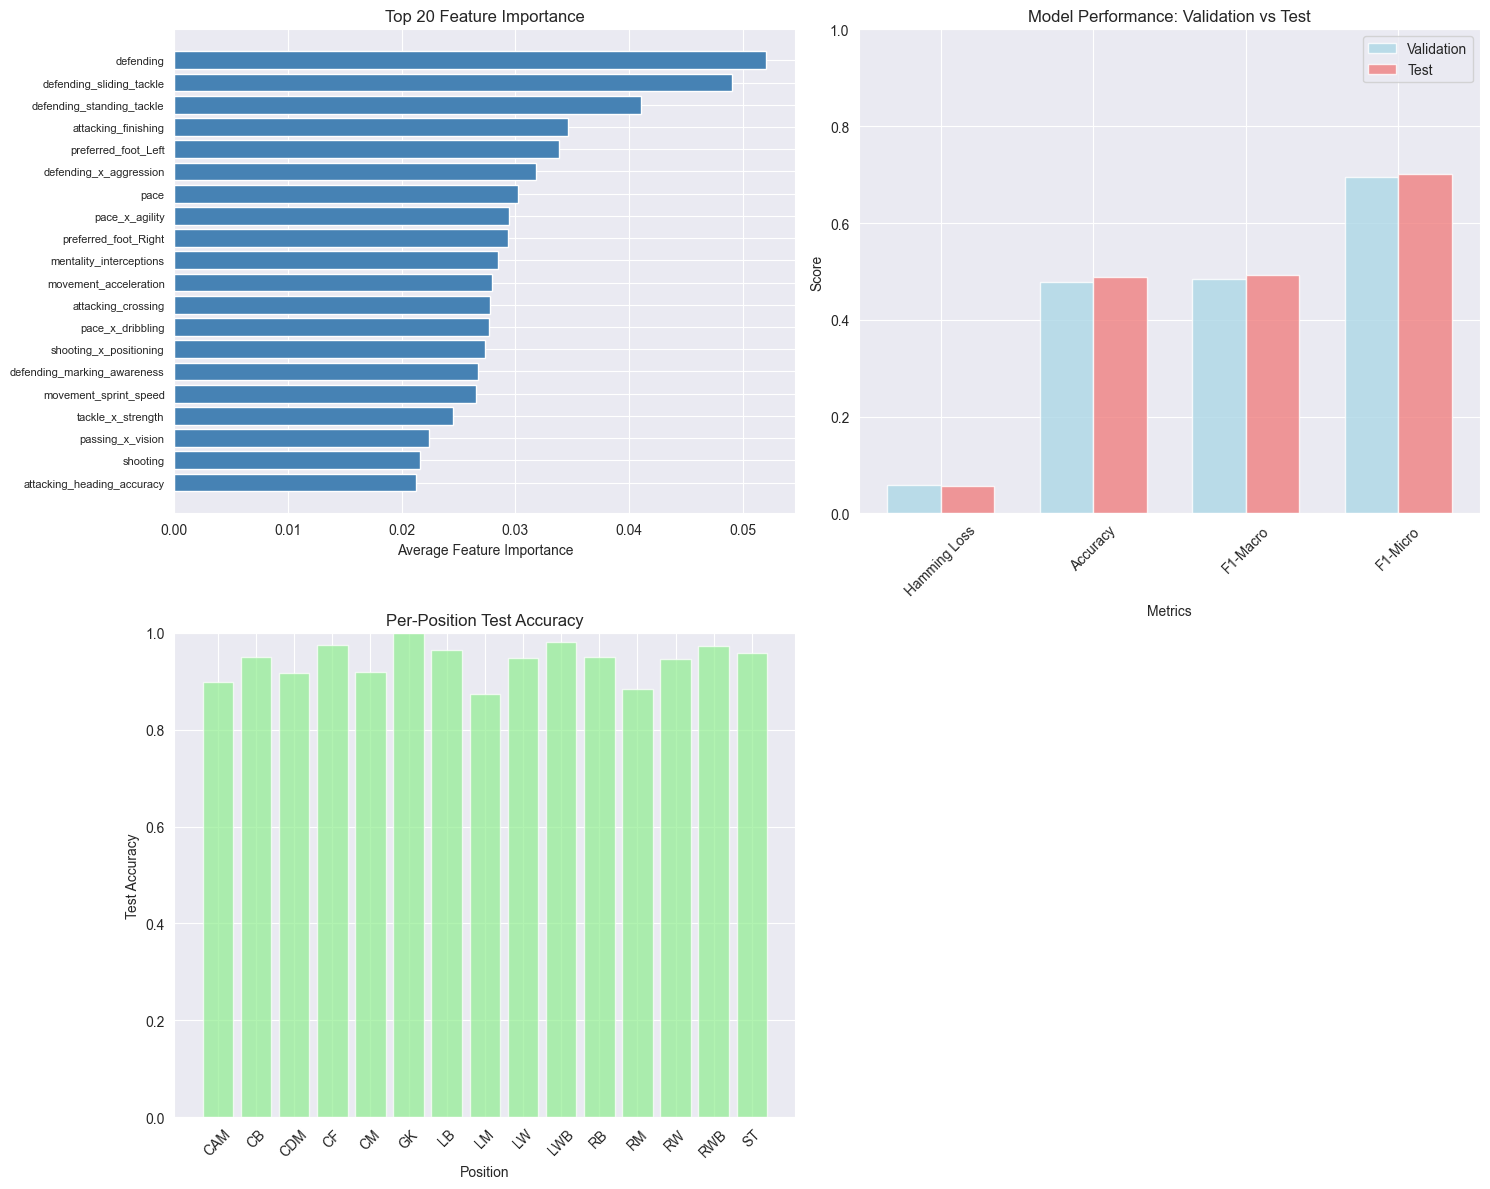

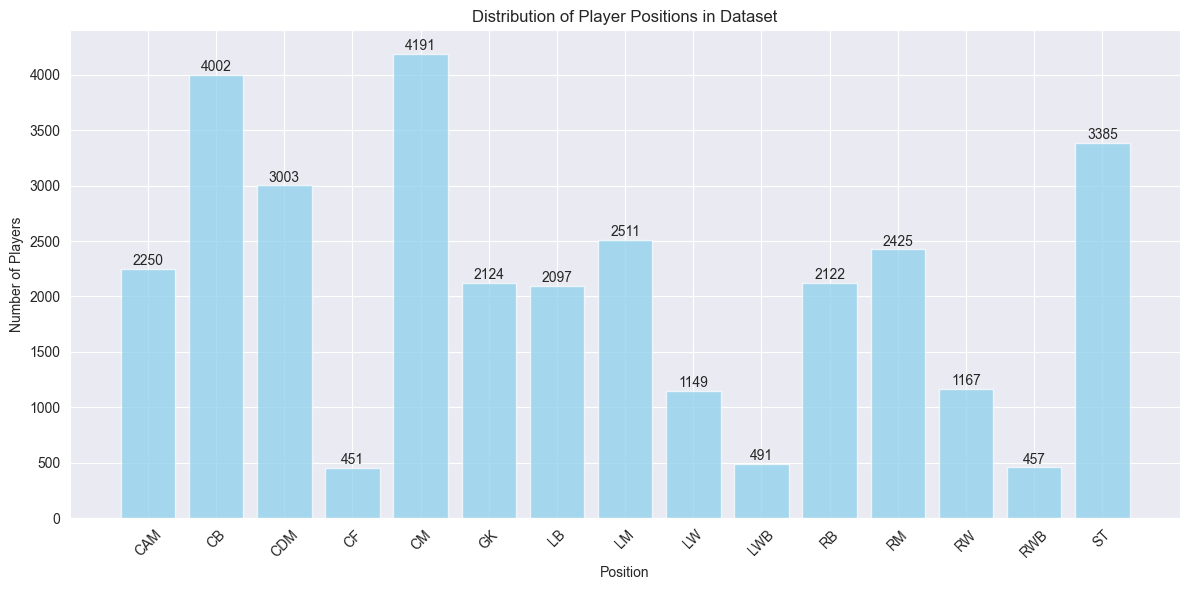

In [21]:
# VISUALIZATIONS
print("\n📊 Step 14: Creating visualizations...")

# Create figure with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Feature Importance
ax1 = axes[0, 0]
top_20_features = mean_importance.head(20)
ax1.barh(range(len(top_20_features)), top_20_features.values, color='steelblue')
ax1.set_yticks(range(len(top_20_features)))
ax1.set_yticklabels(top_20_features.index, fontsize=8)
ax1.set_xlabel('Average Feature Importance')
ax1.set_title('Top 20 Feature Importance')
ax1.invert_yaxis()

# Plot 2: Model Performance Comparison
ax2 = axes[0, 1]
metrics = ['Hamming Loss', 'Accuracy', 'F1-Macro', 'F1-Micro']
val_values = [val_hamming, val_accuracy, val_f1_macro, val_f1_micro]
test_values = [test_hamming, test_accuracy, test_f1_macro, test_f1_micro]

x = np.arange(len(metrics))
width = 0.35

ax2.bar(x - width/2, val_values, width, label='Validation', alpha=0.8, color='lightblue')
ax2.bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='lightcoral')
ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.set_title('Model Performance: Validation vs Test')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics, rotation=45)
ax2.legend()
ax2.set_ylim(0, 1)

# Plot 3: Per-Position Accuracy
ax3 = axes[1, 0]
positions = list(position_scores.keys())
accuracies = list(position_scores.values())
bars = ax3.bar(positions, accuracies, color='lightgreen', alpha=0.7)
ax3.set_xlabel('Position')
ax3.set_ylabel('Test Accuracy')
ax3.set_title('Per-Position Test Accuracy')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylim(0, 1)

# Plot 4: Hide the empty subplot
ax4 = axes[1, 1]
ax4.axis('off')  # Turn off the 4th subplot

plt.tight_layout()
plt.show()

# Additional visualization: Position distribution
plt.figure(figsize=(12, 6))
position_counts = [y[pos].sum() for pos in y.columns]
bars = plt.bar(y.columns, position_counts, color='skyblue', alpha=0.7)
plt.xlabel('Position')
plt.ylabel('Number of Players')
plt.title('Distribution of Player Positions in Dataset')
plt.xticks(rotation=45)

# Add value labels
for bar, count in zip(bars, position_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
#  MODEL SAVING

# Create models folder if it doesn't exist
import os
if not os.path.exists('../models'):
    os.makedirs('../models')
    print("Created 'models/' folder")

# Save all necessary components
model_artifacts = {
    'model': xgb_model,
    'ohe_encoder': ohe,
    'mlb_encoder': mlb,
    'oe_encoder': oe,
    'selected_features': selected_features,
    'feature_importance': mean_importance,
    'outlier_bounds': outlier_bounds,
    'median_release_clause': median_val
}

# Save to models folder
joblib.dump(model_artifacts, '../models/fifa_model_complete.pkl')
joblib.dump(xgb_model, '../models/fifa_xgb_model.pkl')
joblib.dump(ohe, '../models/fifa_ohe_encoder.pkl')
joblib.dump(mlb, '../models/fifa_mlb_encoder.pkl')
joblib.dump(oe, '../models/fifa_oe_encoder.pkl')

print("  Models saved to 'models/' folder")

#  SUMMARY REPORT

print("SUMMARY REPORT")


print(f"   FINAL RESULTS SUMMARY:")
print(f"   Dataset size: {len(df):,} players")
print(f"   Features used: {len(selected_features)} (from {X_train_final.shape[1]} total)")
print(f"   Positions predicted: {len(y.columns)}")
print(f"")
print(f"     Model Performance:")
print(f"      Test Accuracy: {test_accuracy:.4f}")
print(f"      Test F1-Macro: {test_f1_macro:.4f}")
print(f"      Test Hamming Loss: {test_hamming:.4f}")

print(f"   Best performing positions:")
sorted_positions = sorted(position_scores.items(), key=lambda x: x[1], reverse=True)
for pos, score in sorted_positions[:5]:
    print(f"   {pos}: {score:.4f}")

print(f"  Files created:")
print(f"   - models/fifa_model_complete.pkl (complete pipeline)")
print(f"   - models/fifa_xgb_model.pkl (trained model)")
print(f"   - models/fifa_ohe_encoder.pkl (categorical encoder)")
print(f"   - models/fifa_mlb_encoder.pkl (multi-label encoder)")
print(f"   - models/fifa_oe_encoder.pkl (ordinal encoder)")

print(f"    Next steps for improvement:")
print(f"   - Try different hyperparameters")
print(f"   - Add more features or feature engineering")
print(f"   - Try ensemble methods")
print(f"   - Analyze misclassified examples")



  Models saved to 'models/' folder
SUMMARY REPORT
   FINAL RESULTS SUMMARY:
   Dataset size: 1,917 players
   Features used: 45 (from 108 total)
   Positions predicted: 15

     Model Performance:
      Test Accuracy: 0.4893
      Test F1-Macro: 0.4936
      Test Hamming Loss: 0.0575
   Best performing positions:
   GK: 1.0000
   LWB: 0.9807
   CF: 0.9744
   RWB: 0.9734
   LB: 0.9640
  Files created:
   - models/fifa_model_complete.pkl (complete pipeline)
   - models/fifa_xgb_model.pkl (trained model)
   - models/fifa_ohe_encoder.pkl (categorical encoder)
   - models/fifa_mlb_encoder.pkl (multi-label encoder)
   - models/fifa_oe_encoder.pkl (ordinal encoder)
    Next steps for improvement:
   - Try different hyperparameters
   - Add more features or feature engineering
   - Try ensemble methods
   - Analyze misclassified examples
